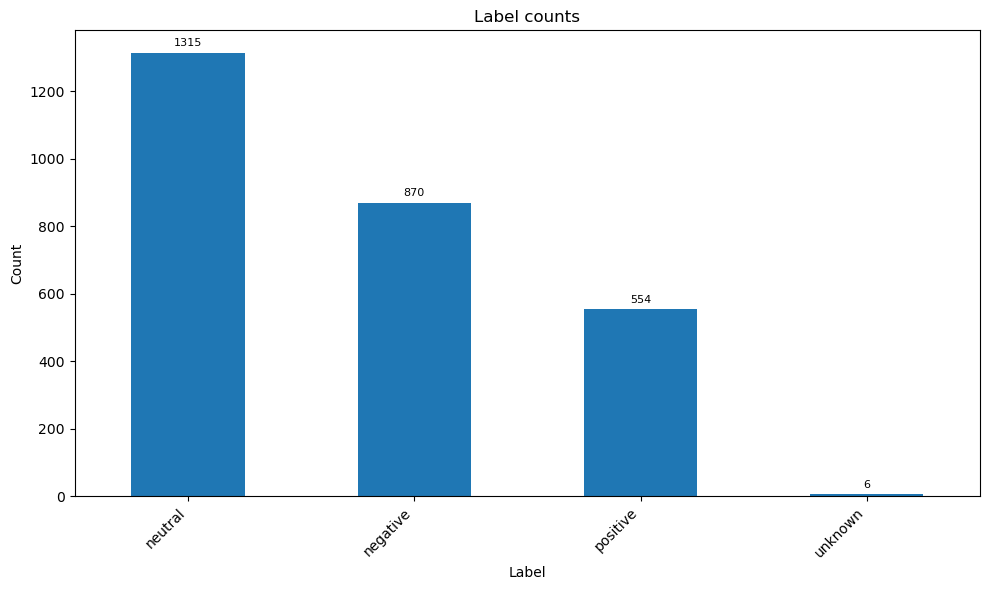

In [161]:
import pandas as pd
import os
import matplotlib.pyplot as plt

noise = '_text_noise_T=top4_paper_S=5'
folder = 'text_noise'

out = os.path.join('out', folder + noise)
os.makedirs(out, exist_ok=True)
results = pd.read_csv(os.path.join('..', 'out', folder, 'prediction' + noise + '.csv'))

# normalize labels and predictions to avoid mismatches
results['label'] = results['label'].astype(str).str.strip().str.lower()
results['prediction'] = results['prediction'].astype(str).str.strip().str.lower()

labels = results['label']

# count occurrences
counts = labels.value_counts().sort_values(ascending=False)

# plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='C0')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label counts')
plt.xticks(rotation=45, ha='right')

# annotate counts on bars
for i, v in enumerate(counts):
    plt.text(i, v + max(counts) * 0.01, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

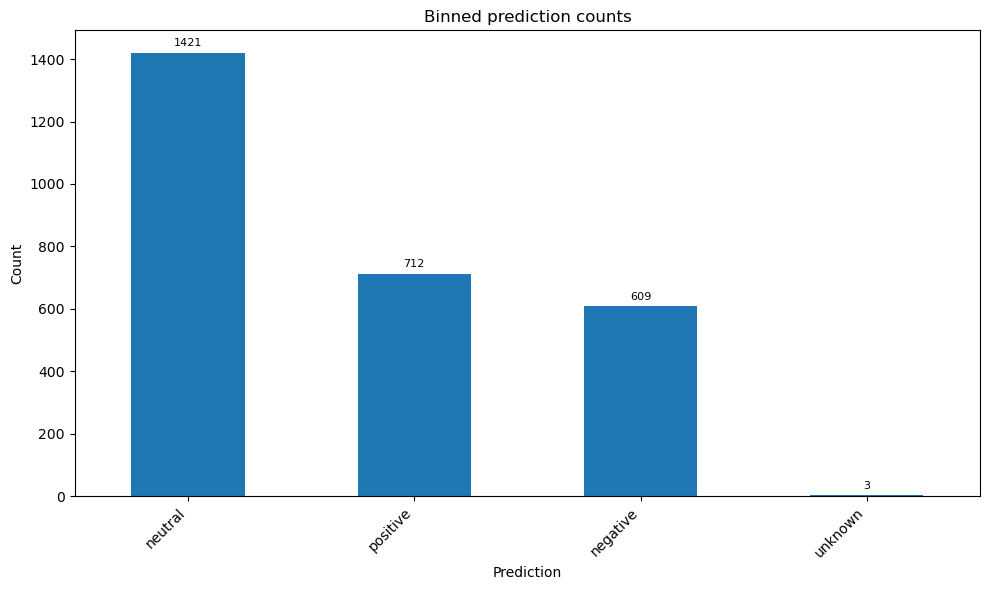

In [162]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# bin predictions which are not 'neutral', 'negative', or 'positive' to 'unknown'
allowed = {'neutral', 'positive', 'negative'}
results['prediction_binned'] = results['prediction'].where(results['prediction'].isin(allowed), 'unknown')

y_pred = results['prediction_binned']

# count occurrences for binned predictions
counts = y_pred.value_counts().sort_values(ascending=False)

# plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='C0')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Binned prediction counts')
plt.xticks(rotation=45, ha='right')

# annotate counts on bars
for i, v in enumerate(counts):
    plt.text(i, v + max(counts) * 0.01, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


Classification report (binned predictions):

              precision    recall  f1-score   support

    positive     0.4607    0.5921    0.5182       554
     neutral     0.6854    0.7407    0.7120      1315
    negative     0.7077    0.4954    0.5828       870
     unknown     0.0000    0.0000    0.0000         6

    accuracy                         0.6313      2745
   macro avg     0.4635    0.4570    0.4532      2745
weighted avg     0.6456    0.6313    0.6304      2745


Per-class summary:
positive: precision=0.4607, recall=0.5921, f1=0.5182, support=554
neutral: precision=0.6854, recall=0.7407, f1=0.7120, support=1315
negative: precision=0.7077, recall=0.4954, f1=0.5828, support=870
unknown: precision=0.0000, recall=0.0000, f1=0.0000, support=6


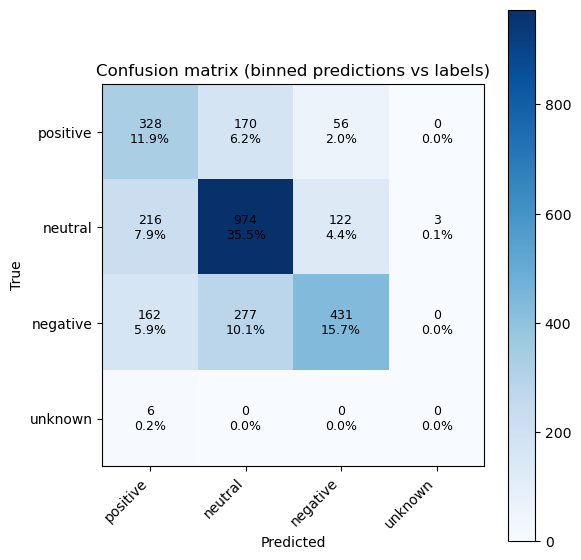

In [163]:
import numpy as np

y_true = results['label']
y_pred = results['prediction_binned']

preferred = ['positive', 'neutral', 'negative', 'unknown']
present = set(y_true.unique()) | set(y_pred.unique())
labels = [l for l in preferred if l in present]
if not labels:
    labels = sorted(list(present))

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_sum = cm.sum()

print('\nClassification report (binned predictions):\n')
print(classification_report(y_true, y_pred, labels=labels, zero_division=0, digits=4))

precisions, recalls, f1s, supports = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
print('\nPer-class summary:')
for lab, p, r, f, s in zip(labels, precisions, recalls, f1s, supports):
    print(f"{lab}: precision={p:.4f}, recall={r:.4f}, f1={f:.4f}, support={s}")

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
ax.set_title('Confusion matrix (binned predictions vs labels)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = int(cm[i, j])
        pct = (count / cm_sum * 100) if cm_sum > 0 else 0.0
        ax.text(j, i, f"{count}\n{pct:.1f}%", ha='center', va='center', color='black', fontsize=9)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig(os.path.join(out, 'CM_all'))
plt.show()

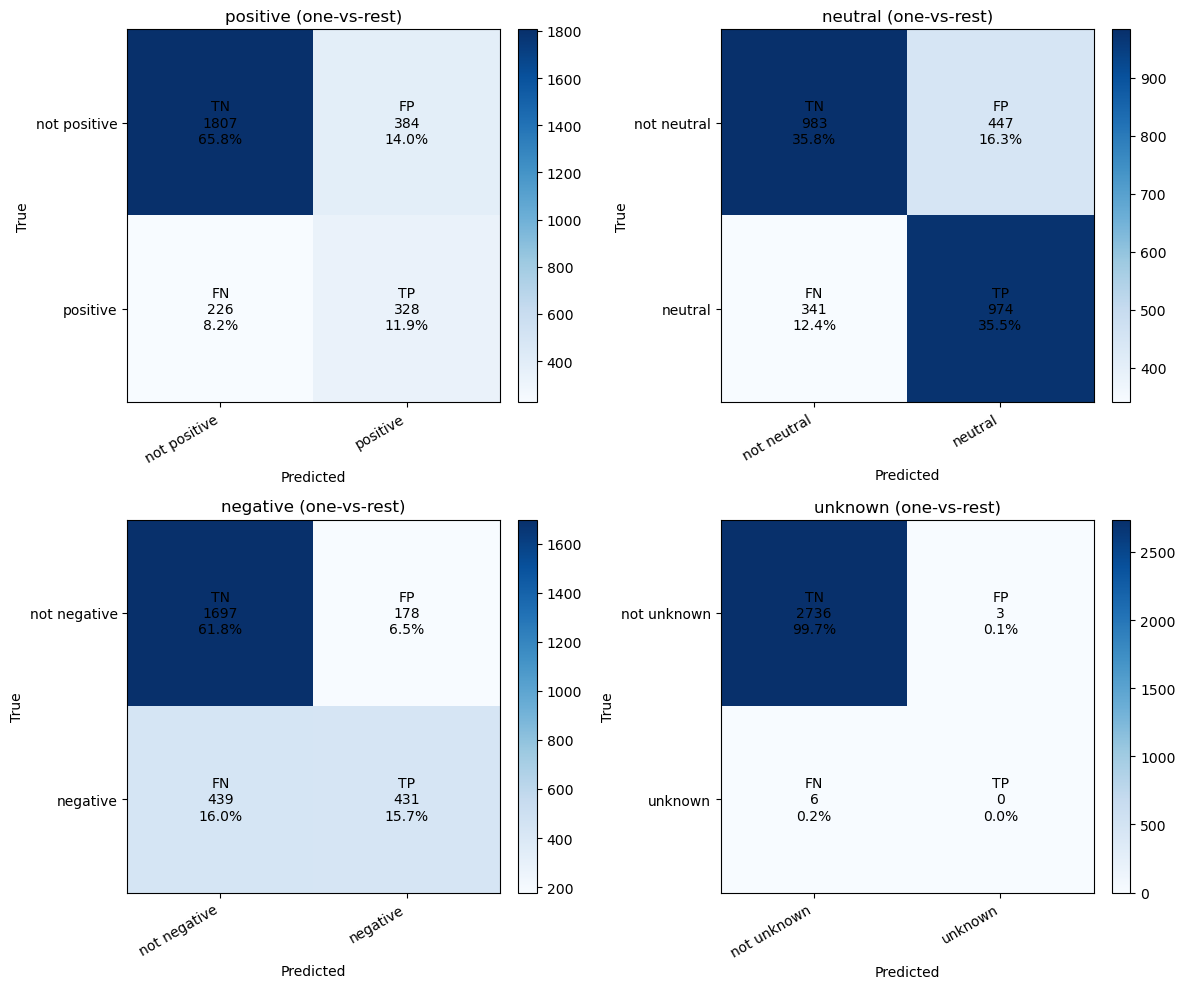

In [164]:
# Per-class 2x2 TP/FP/FN/TN plots (one-vs-rest), arranged in a 2x2 grid using a blue colormap
import numpy as np

# use normalized/binned columns
y_true = results['label']
y_pred = results['prediction_binned']

# preferred ordering and classes present
preferred = ['positive', 'neutral', 'negative', 'unknown']
present = set(y_true.unique()) | set(y_pred.unique())
classes = [c for c in preferred if c in present]
if not classes:
    classes = sorted(list(present))

# layout: fixed 2x2 grid per your request
grid_rows, grid_cols = 2, 2
n = len(classes)
fig, axes = plt.subplots(int(grid_rows), int(grid_cols), figsize=(6 * grid_cols, 5 * grid_rows))
axes = np.array(axes).reshape(int(grid_rows), int(grid_cols))

total = len(y_true)
for idx in range(int(grid_rows) * int(grid_cols)):
    r = idx // int(grid_cols)
    c = idx % int(grid_cols)
    ax = axes[r, c]
    if idx >= n:
        ax.axis('off')
        continue
    cls = classes[idx]

    # binary masks
    true_pos = (y_true == cls)
    pred_pos = (y_pred == cls)

    tp = int((true_pos & pred_pos).sum())
    fp = int((~true_pos & pred_pos).sum())
    fn = int((true_pos & ~pred_pos).sum())
    tn = int((~true_pos & ~pred_pos).sum())

    cm = np.array([[tn, fp], [fn, tp]])

    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_title(f'{cls} (one-vs-rest)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels([f'not {cls}', cls], rotation=30, ha='right')
    ax.set_yticklabels([f'not {cls}', cls])

    # annotate with name, count, and percent of total
    labels_and_counts = [[('TN', tn), ('FP', fp)], [('FN', fn), ('TP', tp)]]
    for i in range(int(2)):
        for j in range(int(2)):
            name, cnt = labels_and_counts[i][j]
            pct_total = (cnt / total * 100) if total > 0 else 0.0
            # percent of class support (for TP/FN use support of true positives)
            support = int(true_pos.sum())
            pct_of_support = (cnt / support * 100) if support > 0 and name in ('TP', 'FN') else pct_total
            ax.text(j, i, f"{name}\n{cnt}\n{pct_total:.1f}%", ha='center', va='center', color='black', fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#save fig as svg
plt.savefig(os.path.join(out, 'CM_perClass.svg'))
plt.show()


In [165]:
# Save TP/FP/FN/TN (one-vs-rest) per class into a CSV
import pandas as pd
from pathlib import Path

# reuse y_true / y_pred computed earlier in the notebook
# determine classes as before
preferred = ['positive', 'neutral', 'negative', 'unknown']
present = set(y_true.unique()) | set(y_pred.unique())
classes = [c for c in preferred if c in present]
if not classes:
    classes = sorted(list(present))

rows = []
total = len(y_true)
for cls in classes:
    true_pos = (y_true == cls)
    pred_pos = (y_pred == cls)
    tp = int((true_pos & pred_pos).sum())
    fp = int((~true_pos & pred_pos).sum())
    fn = int((true_pos & ~pred_pos).sum())
    tn = int((~true_pos & ~pred_pos).sum())
    support = int(true_pos.sum())
    rows.append({
        'class': cls,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'support': support,
        'total': total,
        'pct_support_of_total': (support / total * 100) if total > 0 else 0.0,
    })

out_df = pd.DataFrame(rows)
# write into the analysis folder next to this notebook
out_path = os.path.join(out, 'tp_fp_fn_tn_per_class.csv')
out_df.to_csv(out_path, index=False)

# show the table for convenience
print(out_df.to_string(index=False))


   class  tp  fp  fn   tn  support  total  pct_support_of_total
positive 328 384 226 1807      554   2745             20.182149
 neutral 974 447 341  983     1315   2745             47.905282
negative 431 178 439 1697      870   2745             31.693989
 unknown   0   3   6 2736        6   2745              0.218579


In [14]:
unmodified = ['out/unmodified/tp_fp_fn_tn_per_class.csv']

v60_a002_snr5 = ['out/videostr_60_audioamp_002_snr_5_audio_noise/tp_fp_fn_tn_per_class.csv', 'out/videostr_60_audioamp_002_snr_5_visual_noise/tp_fp_fn_tn_per_class.csv', 'out/videostr_60_audioamp_002_snr_5_audio_visual_noise/tp_fp_fn_tn_per_class.csv']

v100_a05_snr20 = ['out/videostr_100_audioamp_05_snr_-20_audio_noise/tp_fp_fn_tn_per_class.csv', 'out/videostr_100_audioamp_05_snr_-20_visual_noise/tp_fp_fn_tn_per_class.csv', 'out/videostr_100_audioamp_05_snr_-20_audio_visual_noise/tp_fp_fn_tn_per_class.csv']

all_data = [unmodified, v60_a002_snr5, v100_a05_snr20]
classes = ['positive', 'neutral', 'negative', 'unknown']

all_f1s = []
all_recalls = []
all_precisions = []

for data in all_data:
    precisions = []
    recalls = []
    f1s = []

    for file in data:
        precision = pd.DataFrame(columns=classes)
        recall = pd.DataFrame(columns=classes)
        f1 = pd.DataFrame(columns=classes)
        csv = pd.read_csv(file)
        for cl in classes:
            entry_cl = csv[csv['class'] == cl]
            precision[cl] = entry_cl['tp'] / (entry_cl['tp'] + entry_cl['fp'])
            recall[cl] = entry_cl['tp'] / (entry_cl['tp'] + entry_cl['fn'])
            f1[cl] = 2 * precision[cl] * recall[cl] / (precision[cl] + recall[cl])
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    all_f1s.append(f1s)
    all_precisions.append(precisions)
    all_precisions.append(recalls)


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# config: expects `all_data` and `out` (output folder path) to exist in the notebook
group_names = ['unmodified', 'v60_a002_snr5', 'v100_a05_snr20']
target_classes = ['positive', 'neutral', 'negative', 'unknown']

# class fill colors (distinct)
class_colors = {
    'positive': 'tab:green',
    'neutral': 'tab:blue',
    'negative': 'tab:purple',
    'unknown': 'tab:gray'
}

# noise edge colors (for marker edges / legend)
noise_edge_colors = {
    'unmodified': 'k',
    'audio_noise': 'tab:orange',
    'visual_noise': 'tab:red',
    'audio_visual_noise': 'tab:brown',
    'other': 'tab:gray'
}

def infer_noise_label(path):
    p = str(path).lower()
    if 'audio_visual' in p or 'audio-visual' in p or 'audio_visual_noise' in p:
        return 'audio_visual_noise'
    if 'audio_noise' in p or 'audio-noise' in p:
        return 'audio_noise'
    if 'visual_noise' in p or 'visual-noise' in p:
        return 'visual_noise'
    if 'unmodified' in p or 'orig' in p or 'clean' in p:
        return 'unmodified'
    return 'other'

# collect points: list of dicts with keys: group_idx, group_name, file_idx, class_name, noise_label, precision, recall, f1
points = []

for gi, files in enumerate(all_data):
    for fi, file in enumerate(files):
        # robust path reading
        df = None
        try:
            df = pd.read_csv(file)
        except Exception:
            # try common fallbacks: file may be a folder path pointing to tp_fp... csv inside
            try:
                alt = file
                # if it's a folder, try the standard CSV name inside
                if os.path.isdir(alt):
                    alt = os.path.join(alt, 'tp_fp_fn_tn_per_class.csv')
                else:
                    # try relative to analysis/out
                    alt = os.path.join('..', 'analysis', 'out', os.path.basename(file))
                df = pd.read_csv(alt)
            except Exception:
                pass
        if df is None:
            # skip unreadable file but keep placeholders (NaN) so counts align
            for ci, cl in enumerate(target_classes):
                points.append({
                    'group_idx': gi,
                    'group_name': group_names[gi] if gi < len(group_names) else f'group_{gi}',
                    'file_idx': fi,
                    'class_name': cl,
                    'noise_label': infer_noise_label(file),
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1': np.nan
                })
            continue

        # compute per-class metrics
        for ci, cl in enumerate(target_classes):
            row = df[df['class'] == cl]
            if row.empty:
                tp = fp = fn = 0.0
            else:
                tp = float(row['tp'].values[0])
                fp = float(row['fp'].values[0])
                fn = float(row['fn'].values[0])
            prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
            rec = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            f1 = 2 * prec * rec / (prec + rec) if (not np.isnan(prec) and not np.isnan(rec) and (prec + rec) > 0) else np.nan
            points.append({
                'group_idx': gi,
                'group_name': group_names[gi] if gi < len(group_names) else f'group_{gi}',
                'file_idx': fi,
                'class_name': cl,
                'noise_label': infer_noise_label(file),
                'precision': prec,
                'recall': rec,
                'f1': f1
            })

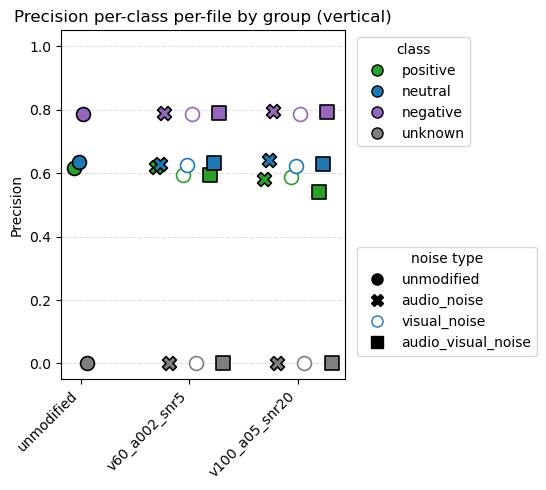

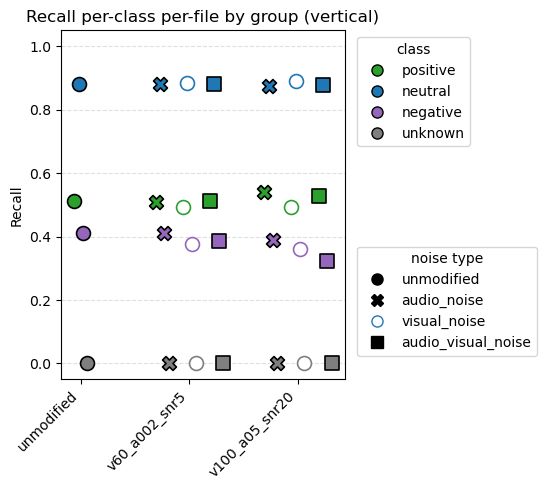

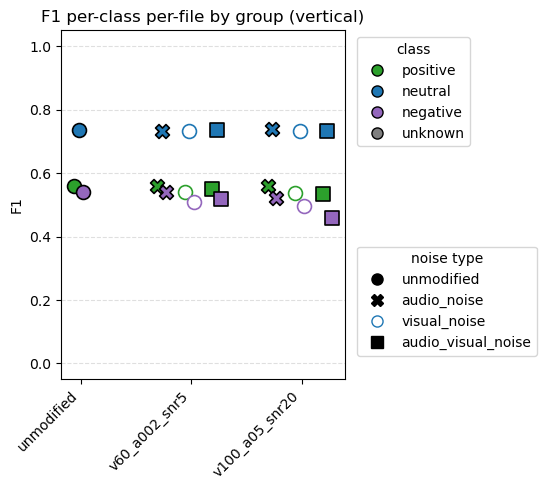

In [16]:
import os
from matplotlib.lines import Line2D

def plot_metric(metric_key, points, out_folder, filename):
    fig, ax = plt.subplots(figsize=(1.2 * len(group_names) + 2, 5))
    x_positions = np.arange(len(group_names))
    handles_classes = {}
    handles_noise = {}

    # determine per-group file counts
    files_per_group = {}
    for p in points:
        files_per_group.setdefault(p['group_idx'], set()).add(p['file_idx'])
    files_per_group = {k: sorted(list(v)) for k, v in files_per_group.items()}

    # mapping noise type -> marker symbol and whether it should be drawn unfilled
    marker_map = {
        'unmodified': ('o', False),        # filled dot
        'audio_noise': ('X', False),       # cross
        'visual_noise': ('o', True),       # unfilled dot
        'audio_visual_noise': ('s', False),# square
        'other': ('D', False)              # diamond for anything else
    }

    # plotting each point with face color = class, marker shape = noise type
    for p in points:
        gi = p['group_idx']
        fn = p['file_idx']
        cls = p['class_name']
        noise = p['noise_label']
        val = p[metric_key]

        # horizontal offsets: file index within group + class offset
        files_in_group = files_per_group.get(gi, [fn])
        if len(files_in_group) <= 1:
            file_offset = 0.0
        else:
            file_pos = files_in_group.index(fn)
            file_offset = np.linspace(-0.25, 0.25, len(files_in_group))[file_pos]
        class_offset = {'positive': -0.06, 'neutral': -0.02, 'negative': 0.02, 'unknown': 0.06}.get(cls, 0.0)

        x = x_positions[gi] + file_offset + class_offset
        y = val

        marker, unfilled = marker_map.get(noise, marker_map['other'])
        facec = class_colors.get(cls, 'tab:gray')
        # determine face/edge colors depending on unfilled flag
        if unfilled:
            mfc = 'white'
            mec = facec
        else:
            mfc = facec
            mec = 'k'

        sc = ax.scatter(x, y, marker=marker, facecolor=mfc, edgecolor=mec, linewidth=1.2, s=100, zorder=3)

        # build class legend (filled marker with class color)
        if cls not in handles_classes:
            handles_classes[cls] = Line2D([0], [0], marker='o', color='w', label=cls,
                                          markerfacecolor=class_colors.get(cls, 'tab:gray'), markersize=8, markeredgecolor='k')

        # build noise legend (marker shapes only)
        if noise not in handles_noise:
            mk, mk_unfilled = marker_map.get(noise, marker_map['other'])
            if mk_unfilled:
                leg_mfc = 'white'
                leg_mec = class_colors.get('neutral', 'k')
            else:
                leg_mfc = 'k'
                leg_mec = 'k'
            handles_noise[noise] = Line2D([0], [0], marker=mk, color='w', label=noise,
                                           markerfacecolor=leg_mfc, markeredgecolor=leg_mec, markersize=8, linewidth=0)

    ax.set_xticks(x_positions)
    ax.set_xticklabels([group_names[i] if i < len(group_names) else f'group_{i}' for i in x_positions], rotation=45, ha='right')
    ax.set_ylabel(metric_key.capitalize())
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.title(f'{metric_key.capitalize()} per-class per-file by group (vertical)')

    # class legend (filled markers)
    if handles_classes:
        leg1 = ax.legend(handles=list(handles_classes.values()), title='class', bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.add_artist(leg1)
    # noise legend (marker shapes)
    if handles_noise:
        ax.legend(handles=list(handles_noise.values()), title='noise type', bbox_to_anchor=(1.02, 0.4), loc='upper left')

    plt.tight_layout()
    os.makedirs(out_folder, exist_ok=True)
    save_path = os.path.join(out_folder, filename)
    plt.savefig(save_path, dpi=200)
    plt.show()

out = os.path.join('out', 'metrics')
os.makedirs(out, exist_ok=True)

# create plots and save into `out` (reuse existing `out` variable from notebook)
plot_metric('precision', points, out, 'group_precision_per_class.png')
plot_metric('recall', points, out, 'group_recall_per_class.png')
plot_metric('f1', points, out, 'group_f1_per_class.png')

       modality    class  precision   recall       f1
    char_delete negative   0.707718 0.495402 0.582826
    char_delete  neutral   0.685433 0.740684 0.711988
    char_delete positive   0.460674 0.592058 0.518167
    char_delete  unknown   0.000000 0.000000      NaN
   char_replace negative   0.707718 0.495402 0.582826
   char_replace  neutral   0.685433 0.740684 0.711988
   char_replace positive   0.460674 0.592058 0.518167
   char_replace  unknown   0.000000 0.000000      NaN
       keyboard negative   0.707718 0.495402 0.582826
       keyboard  neutral   0.685433 0.740684 0.711988
       keyboard positive   0.460674 0.592058 0.518167
       keyboard  unknown   0.000000 0.000000      NaN
            ocr negative   0.707718 0.495402 0.582826
            ocr  neutral   0.685433 0.740684 0.711988
            ocr positive   0.460674 0.592058 0.518167
            ocr  unknown   0.000000 0.000000      NaN
synonym_replace negative   0.707718 0.495402 0.582826
synonym_replace  neutral   0

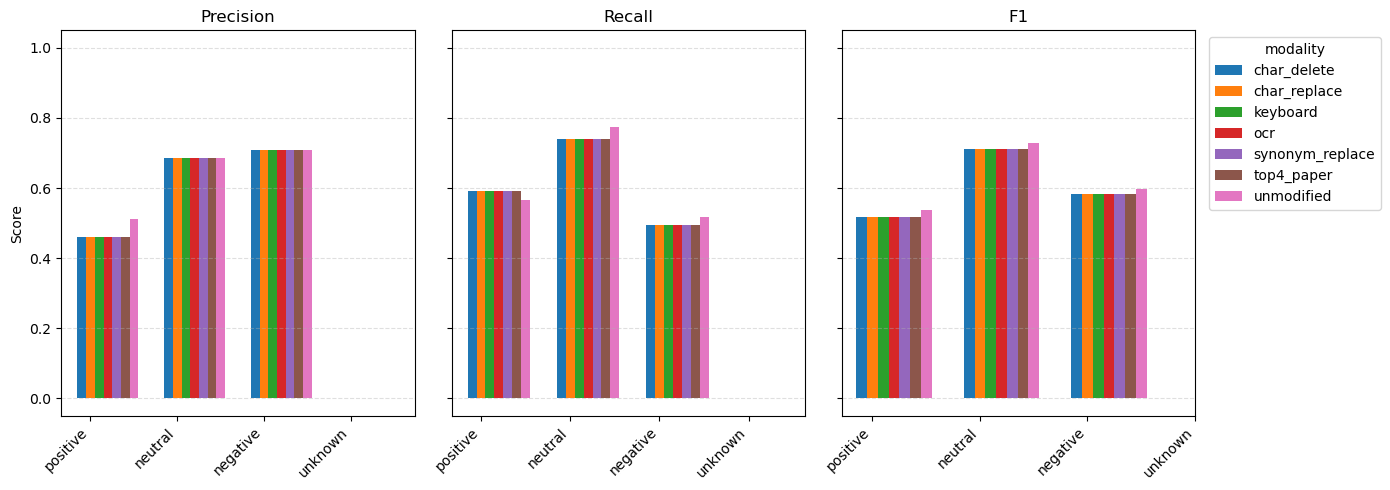

In [166]:
# python
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# files (as requested): use the CSVs you mentioned
files = {
    'char_delete': 'out/text_noise_text_noise_T=char_delete_S=5/tp_fp_fn_tn_per_class.csv',
    'char_replace': 'out/text_noise_text_noise_T=char_replace_S=5/tp_fp_fn_tn_per_class.csv',
    'keyboard': 'out/text_noise_text_noise_T=keyboard_S=5/tp_fp_fn_tn_per_class.csv',
    'ocr': 'out/text_noise_text_noise_T=ocr_S=5/tp_fp_fn_tn_per_class.csv',
    'synonym_replace': 'out/text_noise_text_noise_T=synonym_replace_S=5/tp_fp_fn_tn_per_class.csv',
    'top4_paper': 'out/text_noise_text_noise_T=top4_paper_S=5/tp_fp_fn_tn_per_class.csv',
    'unmodified': 'out/unmodified_test_text/tp_fp_fn_tn_per_class.csv'
}

#files = {
#    'bandlimit': 'out/audio_noise_audio_noise_A=bandlimit_S=5/tp_fp_fn_tn_per_class.csv',
#    'clipping': 'out/audio_noise_audio_noise_A=clipping_S=5/tp_fp_fn_tn_per_class.csv',
#    'mp3': 'out/audio_noise_audio_noise_A=mp3_S=5/tp_fp_fn_tn_per_class.csv',
#    'reverb': 'out/audio_noise_audio_noise_A=reverb_S=5/tp_fp_fn_tn_per_class.csv',
#    'snr_white': 'out/audio_noise_audio_noise_A=snr_white_S=5/tp_fp_fn_tn_per_class.csv',
#    'unmodified': 'out/unmodified_test_audio/tp_fp_fn_tn_per_class.csv'
#}

#files = {
#    'gaussian_noise': 'out/visual_noise_visual_noise_V=gaussian_noise_S=5/tp_fp_fn_tn_per_class.csv',
#    'motion_blur': 'out/visual_noise_visual_noise_V=motion_blur_S=5/tp_fp_fn_tn_per_class.csv',
#    'pixelate': 'out/visual_noise_visual_noise_V=pixelate_S=5/tp_fp_fn_tn_per_class.csv',
#    'zoom_blur': 'out/visual_noise_visual_noise_V=zoom_blur_S=5/tp_fp_fn_tn_per_class.csv',
#    'unmodified': 'out/unmodified_test_visual/tp_fp_fn_tn_per_class.csv'
#}

# preferred class ordering (falls back to found classes)
preferred = ['positive', 'neutral', 'negative', 'unknown']

rows = []
for modality, path in files.items():
    df = pd.read_csv(path)
    df = df.set_index('class')
    for cls in sorted(df.index.unique()):
        tp = float(df.at[cls, 'tp']) if cls in df.index else 0.0
        fp = float(df.at[cls, 'fp']) if cls in df.index else 0.0
        fn = float(df.at[cls, 'fn']) if cls in df.index else 0.0
        prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        rec = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        f1 = 2 * prec * rec / (prec + rec) if (not np.isnan(prec) and not np.isnan(rec) and (prec + rec) > 0) else np.nan
        rows.append({'modality': modality, 'class': cls, 'precision': prec, 'recall': rec, 'f1': f1})

metrics_df = pd.DataFrame(rows)

# ensure consistent class ordering
classes_present = list(dict.fromkeys([c for c in preferred if c in metrics_df['class'].unique()] +
                                    [c for c in metrics_df['class'].unique() if c not in preferred]))
modalities = list(files.keys())

# print table
print(metrics_df.sort_values(['modality', 'class']).to_string(index=False))

# plotting grouped bars: one panel with three subplots (precision/recall/f1)
out_dir = os.path.join('out', 'text_noise_test_metrics')
os.makedirs(out_dir, exist_ok=True)

x = np.arange(len(classes_present))
width = 0.1

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
for i, metric in enumerate(['precision', 'recall', 'f1']):
    ax = axes[i]
    for j, mod in enumerate(modalities):
        vals = [
            metrics_df.loc[(metrics_df['modality'] == mod) & (metrics_df['class'] == cls), metric].values
            for cls in classes_present
        ]
        # extract scalar or NaN
        vals = [v[0] if len(v) else np.nan for v in vals]
        ax.bar(x + (j - 1) * width, vals, width=width, label=mod)
    ax.set_xticks(x)
    ax.set_xticklabels(classes_present, rotation=45, ha='right')
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(metric.capitalize())
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    if i == 0:
        ax.set_ylabel('Score')

axes[-1].legend(title='modality', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
save_path = os.path.join(out_dir, 'metrics_per_modality.png')
plt.savefig(save_path, dpi=200)
plt.show()


In [132]:
# split csv file based on column split, add the str in column split to new file name
df = pd.read_csv('../out/prediction_text_noise.csv')

for split_value, group_df in df.groupby('split'):
    out_path = os.path.join('..', 'out', 'visual_noise', f'prediction_visual_noise_{split_value.split('/')[0]}.csv')
    group_df.to_csv(out_path, index=False)
